In [55]:
import numpy as np
import cv2
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    Concatenate,
    MaxPool2D,
    Dropout,
    Flatten,
)

In [76]:
#import data

imgs0 = np.load('data/imgs_0.npy')
vels0 = np.load('data/vels_0.npy')
imgs1 = np.load('data/imgs_1.npy')
vels1 = np.load('data/vels_1.npy')
#imgs2 = np.load('data/images_24.npy')
#vels2 = np.load('data/vels_24.npy')
imgsf1 = np.load('data/fine_imgs.npy')
velsf1 = np.load('data/fine_vels.npy')
imgsf2 = np.load('data/fine_imgs_2.npy')
velsf2 = np.load('data/fine_vels_2.npy')
imgsf3 = np.load('data/fine_imgs_3.npy')
velsf3 = np.load('data/fine_vels_3.npy')
imgsf4 = np.load('data/fine_imgs_4.npy')
velsf4 = np.load('data/fine_vels_4.npy')
imgsf5 = np.load('data/fine_imgs_5.npy')
velsf5 = np.load('data/fine_vels_5.npy')
imgs = np.concatenate([imgs0, imgs1, imgsf1, imgsf2, imgsf3, imgsf4, imgsf5])
vels = np.concatenate([vels0, vels1, velsf1, velsf2, velsf3, velsf4, velsf5])
print(imgs.shape)
print(vels.shape)

(65263, 90, 160, 1)
(65263, 2)


In [77]:
# remove the data where the robot is not moving

not_moving = np.where(vels[:, 0] == 0.0)[0]

img_data = np.delete(imgs, not_moving, axis=0)
vel_data = np.delete(vels, not_moving, axis=0)

print(img_data.shape)
print(vel_data.shape)

(64664, 90, 160, 1)
(64664, 2)


In [78]:
# identifying how many data points from each class there are

straight = np.where(vel_data[:, 1] == 0.0)[0]
left = np.where(vel_data[:, 1] == 1.0)[0]
right = np.where(vel_data[:, 1] == -1.0)[0]

straight_img = img_data[straight]
left_img = img_data[left]
right_img = img_data[right]

straight_vel = vel_data[straight]
left_vel = vel_data[left]
right_vel = vel_data[right]

print(straight_img.shape)
print(left_img.shape)
print(right_img.shape)

(43875, 90, 160, 1)
(19139, 90, 160, 1)
(1650, 90, 160, 1)


In [79]:
# reduce the data straight and left data so that there's
# an approximately the same number of data points 

straight_keep = straight[:len(straight)//25]
print(straight_keep.shape)
left_keep=left[:len(left)//11]
print(left_keep.shape)
right_keep=right
print(right_keep.shape)
all_keep = np.concatenate([straight_keep, left_keep, right_keep])

(1755,)
(1739,)
(1650,)


In [80]:
img_data = img_data[all_keep]
vel_data=vel_data[all_keep]
print(img_data.shape)
print(vel_data.shape)

(5144, 90, 160, 1)
(5144, 2)


In [81]:
img_data = img_data/255

In [82]:
velocities_to_actions = {
    (0.25, 0.0): np.array([1, 0, 0]),
    (0.25, 1.0): np.array([0, 1, 0]),
    (0.25, -1.0): np.array([0, 0, 1]),
}

actions = np.array([velocities_to_actions[tuple(i)] for i in vel_data])

In [68]:
input_image = Input(shape=(90, 160, 1))
output_image = Conv2D(32, 4, padding="same")(input_image)
output_image = MaxPool2D(4)(output_image)

# output_image = Conv2D(32, 4, padding="same")(output_image)
# output_image = MaxPool2D(2)(output_image)
# output_image = Dropout(0.5)(output_image)

output_image = Conv2D(16, 4, padding="same")(output_image)
output_image = MaxPool2D(4)(output_image)
output_image = Dropout(0.5)(output_image)

# output_image = Conv2D(16, 4, padding="same")(output_image)
# output_image = MaxPool2D(2)(output_image)
# output_image = Dropout(0.5)(output_image)

output_image = Flatten()(output_image)

output_image = Dense(128, activation="relu")(output_image)
output_image = Dropout(0.5)(output_image)

output_image = Dense(64, activation="relu")(output_image)
output_image = Dropout(0.5)(output_image)

output_image = Dense(32, activation="relu")(output_image)
#output_image = Dropout(0.5)(output_image)

#output_image = Dense(16, activation="relu")(output_image)

output_image = Dense(3, activation="softmax")(output_image)


image_net = Model(input_image, output_image)
image_net.summary()
image_net.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 90, 160, 1)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 160, 32)       544       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 22, 40, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 22, 40, 16)        8208      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 10, 16)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 5, 10, 16)         0   

In [69]:
image_net.fit(img_data, actions, batch_size=4, epochs=50, validation_split=0.2)

Epoch 1/50
1029/1029 [==============================] - 17s 17ms/step - loss: 0.8453 - accuracy: 0.6119 - val_loss: 1.3806 - val_accuracy: 0.0000e+00
Epoch 2/50
1029/1029 [==============================] - 18s 17ms/step - loss: 0.6156 - accuracy: 0.7458 - val_loss: 0.9162 - val_accuracy: 0.0000e+00
Epoch 3/50
1029/1029 [==============================] - 18s 17ms/step - loss: 0.5766 - accuracy: 0.7587 - val_loss: 1.0079 - val_accuracy: 0.0019
Epoch 4/50
1029/1029 [==============================] - 18s 18ms/step - loss: 0.5611 - accuracy: 0.7645 - val_loss: 0.7898 - val_accuracy: 0.6016
Epoch 5/50
1029/1029 [==============================] - 18s 18ms/step - loss: 0.5389 - accuracy: 0.7628 - val_loss: 1.1131 - val_accuracy: 0.0000e+00
Epoch 6/50
1029/1029 [==============================] - 18s 17ms/step - loss: 0.5378 - accuracy: 0.7689 - val_loss: 0.8612 - val_accuracy: 0.6064
Epoch 7/50
1029/1029 [==============================] - 16s 15ms/step - loss: 0.5128 - accuracy: 0.7791 - val_lo

In [74]:
image_net.save('/home/fizzer/ros_ws/cnn_trainer/trained_model_rm_straight_bias')

INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/cnn_trainer/trained_model_rm_straight_bias/assets


INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/cnn_trainer/trained_model_rm_straight_bias/assets


In [70]:
imgs0 = np.load('data/images_24.npy')
vels0 = np.load('data/vels_24.npy')

not_moving_val = np.where(vels0[:, 0] == 0.0)[0]

img_data_val = np.delete(imgs0, not_moving_val, axis=0)
vel_data_val = np.delete(vels0, not_moving_val, axis=0)

print(img_data_val.shape)
print(vel_data_val.shape)

(20047, 90, 160, 1)
(20047, 2)


In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


y_pred = image_net.predict(img_data_val)
y_test = vel_data_val

627/627 [==============================] - 13s 21ms/step


In [72]:
import matplotlib.pyplot as plt
actions_to_vels = np.array([(0.25, 0.0), (0.25, 1.0), (0.25, -1.0)])

pred=[]

for p in y_pred:
    arr = list(actions_to_vels[np.argmax(p)])
    pred.append(arr)

pred = np.array(pred)
vels_to_classes = {
    (0.25, 0.0): 0,
    (0.25, 1.0): 1,
    (0.25, -1.0): 2,
}

truth =np.array([vels_to_classes[tuple(i)] for i in y_test])
predictions = np.array([vels_to_classes[tuple(i)] for i in pred])

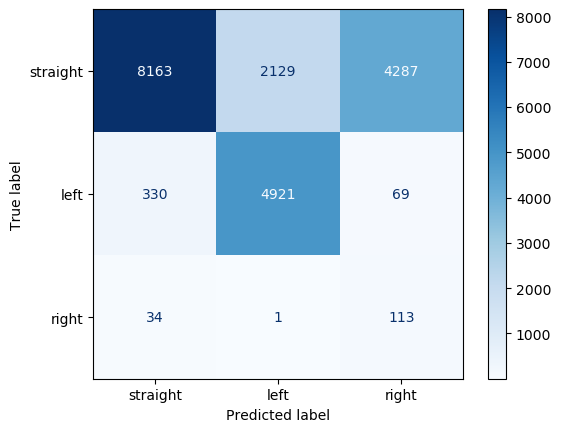

In [73]:
cm = confusion_matrix(truth, predictions)
labels = ['straight', 'left', 'right']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

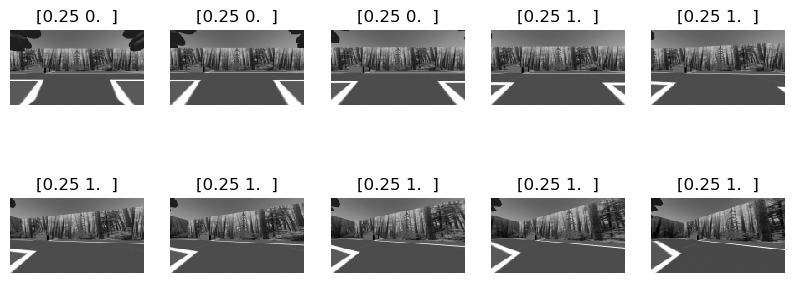

In [68]:
import matplotlib.pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 4))
  
# setting values to rows and column variables
rows = 2
columns = 5
  
# reading images
#idx = np.random.choice(500, size=20)
idx=np.arange(11)
images = img_data[idx]
images = images.squeeze()
#images_plt = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position

for i in range(1,11):

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(str(vel_data[i]))


In [69]:
vel_data[:10]

array([[0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 1.  ],
       [0.25, 1.  ],
       [0.25, 1.  ],
       [0.25, 1.  ],
       [0.25, 1.  ],
       [0.25, 1.  ]])